# 🌍 COVID-19 Global Data Tracker

This project tracks and visualizes global COVID-19 data using Python.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# 📦 Importing libraries
import pandas as pd       # For data manipulation
import numpy as np        # For numerical operations
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns     # For nicer visualizations

# Display plots inside notebook
%matplotlib inline

# Set a nice style
sns.set(style="whitegrid")

In [3]:
# 🔒 Robust data loader: local first, then GitHub mirror
from pathlib import Path
import pandas as pd

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)
LOCAL_FILE = DATA_DIR / "owid_compact.csv"
MIRROR_URL = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"
# If your network struggles with the full file, you can switch to:
# MIRROR_URL = "https://catalog.ourworldindata.org/garden/covid/latest/compact/compact.csv"

def load_data():
    if LOCAL_FILE.exists():
        print(f"✅ Loading local cache: {LOCAL_FILE}")
        df_ = pd.read_csv(LOCAL_FILE)
    else:
        print("🌐 Downloading from mirror (first run may take a bit)…")
        df_ = pd.read_csv(MIRROR_URL)
        # Save a lightweight cache to your repo for offline grading:
        try:
            df_.to_csv(LOCAL_FILE, index=False)
            print(f"💾 Cached a copy to {LOCAL_FILE}")
        except Exception as e:
            print("⚠️ Could not cache locally:", e)
    return df_

df = load_data()

# ---- Standardize expected columns/types ----
# Handle possible column name differences: prefer 'country', fallback to 'location'/'Entity'
if "country" not in df.columns:
    if "location" in df.columns:
        df = df.rename(columns={"location": "country"})
    elif "Entity" in df.columns:
        df = df.rename(columns={"Entity": "country"})
    elif "Country/Region" in df.columns:
        df = df.rename(columns={"Country/Region": "country"})

# Ensure 'date' is datetime
if df["date"].dtype != "datetime64[ns]":
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Sort by country/date (helps with rolling averages)
df = df.sort_values(["country", "date"], ignore_index=True)
print("✅ Data ready:", df.shape, "rows/cols")
df.head()

✅ Loading local cache: data\owid_compact.csv
✅ Data ready: (429435, 67) rows/cols


,iso_code,continent,country,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-05,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-06,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-07,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-08,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-09,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN


In [4]:
# ✅ Sanity checks (fail fast with clear errors)
required_cols = ["country", "date", "new_cases", "new_deaths", "total_cases", "total_deaths"]
missing = [c for c in required_cols if c not in df.columns]
assert not missing, f"Missing required columns: {missing}"

assert df.shape[0] > 0, "DataFrame is empty."
assert df["date"].notna().any(), "'date' has no valid values."
assert df["country"].notna().any(), "'country' has no valid values."

print("All sanity checks passed ✅")

All sanity checks passed ✅


In [5]:
url = "https://catalog.ourworldindata.org/garden/covid/latest/compact/compact.csv"
df = pd.read_csv(url)
df.head()

,country,date,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths,new_deaths,...,population,population_density,median_age,life_expectancy,gdp_per_capita,extreme_poverty,diabetes_prevalence,handwashing_facilities,hospital_beds_per_thousand,human_development_index
0,Afghanistan,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40578801.0,62.215477,16.752001,65.616997,1516.273315,NaN,10.9,48.214695,0.39,NaN
1,Afghanistan,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40578801.0,62.215477,16.752001,65.616997,1516.273315,NaN,10.9,48.214695,0.39,NaN
2,Afghanistan,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40578801.0,62.215477,16.752001,65.616997,1516.273315,NaN,10.9,48.214695,0.39,NaN
3,Afghanistan,2020-01-04,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,...,40578801.0,62.215477,16.752001,65.616997,1516.273315,NaN,10.9,48.214695,0.39,NaN
4,Afghanistan,2020-01-05,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,...,40578801.0,62.215477,16.752001,65.616997,1516.273315,NaN,10.9,48.214695,0.39,NaN


In [6]:
df.shape

(521908, 61)

In [7]:
print(df.columns)

Index(['country', 'date', 'total_cases', 'new_cases', 'new_cases_smoothed',
       'total_cases_per_million', 'new_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_deaths_per_million',
       'new_deaths_per_million', 'new_deaths_smoothed_per_million',
       'excess_mortality', 'excess_mortality_cumulative',
       'excess_mortality_cumulative_absolute',
       'excess_mortality_cumulative_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'icu_patients',
       'icu_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'stringency_index',
       'reproduction_rate', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'total_vaccinations',
    

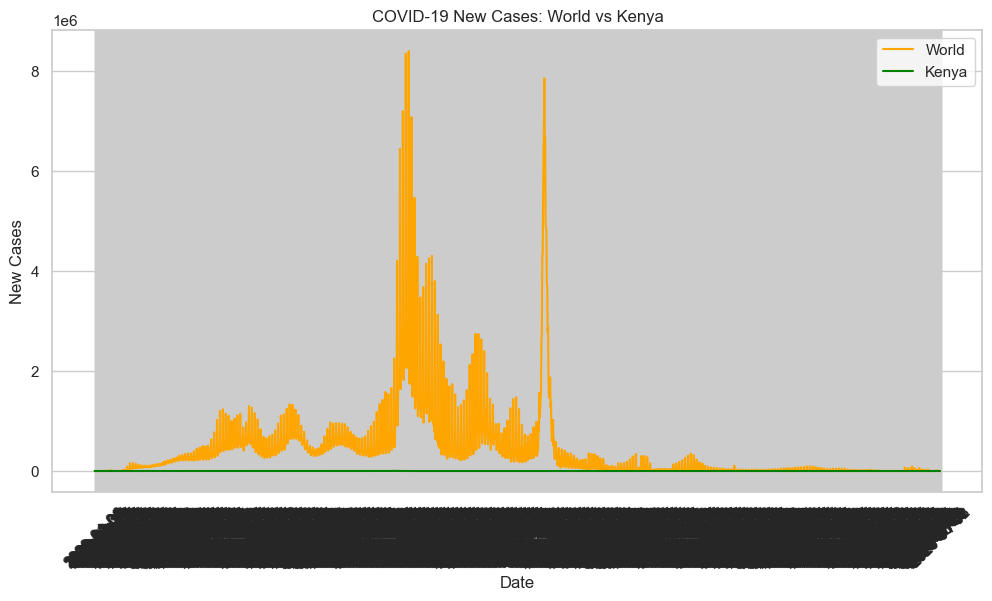

In [8]:
import matplotlib.pyplot as plt

# Filter World and Kenya
world = df[df["country"] == "World"]
kenya = df[df["country"] == "Kenya"]

# Plot new cases
plt.figure(figsize=(12,6))
plt.plot(world["date"], world["new_cases"], label="World", color="orange")
plt.plot(kenya["date"], kenya["new_cases"], label="Kenya", color="green")

# Add titles and labels
plt.title("COVID-19 New Cases: World vs Kenya")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.legend()
plt.xticks(rotation=45)
plt.show()

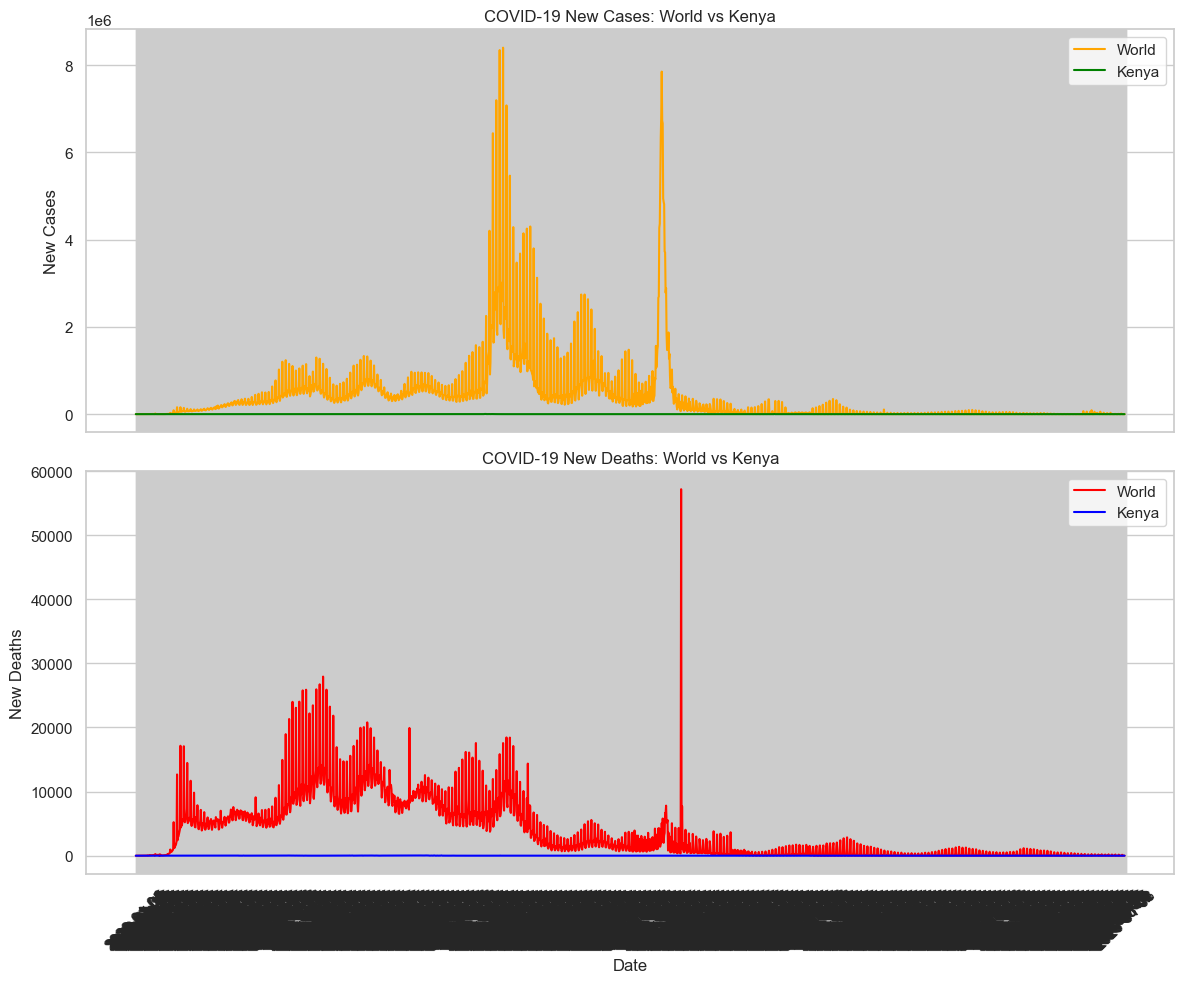

In [9]:
import matplotlib.pyplot as plt

# Filter World and Kenya
world = df[df["country"] == "World"]
kenya = df[df["country"] == "Kenya"]

# Create figure with 2 subplots
fig, axes = plt.subplots(2, 1, figsize=(12,10), sharex=True)

# --- New Cases ---
axes[0].plot(world["date"], world["new_cases"], label="World", color="orange")
axes[0].plot(kenya["date"], kenya["new_cases"], label="Kenya", color="green")
axes[0].set_title("COVID-19 New Cases: World vs Kenya")
axes[0].set_ylabel("New Cases")
axes[0].legend()

# --- New Deaths ---
axes[1].plot(world["date"], world["new_deaths"], label="World", color="red")
axes[1].plot(kenya["date"], kenya["new_deaths"], label="Kenya", color="blue")
axes[1].set_title("COVID-19 New Deaths: World vs Kenya")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("New Deaths")
axes[1].legend()

# Rotate x-axis for readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

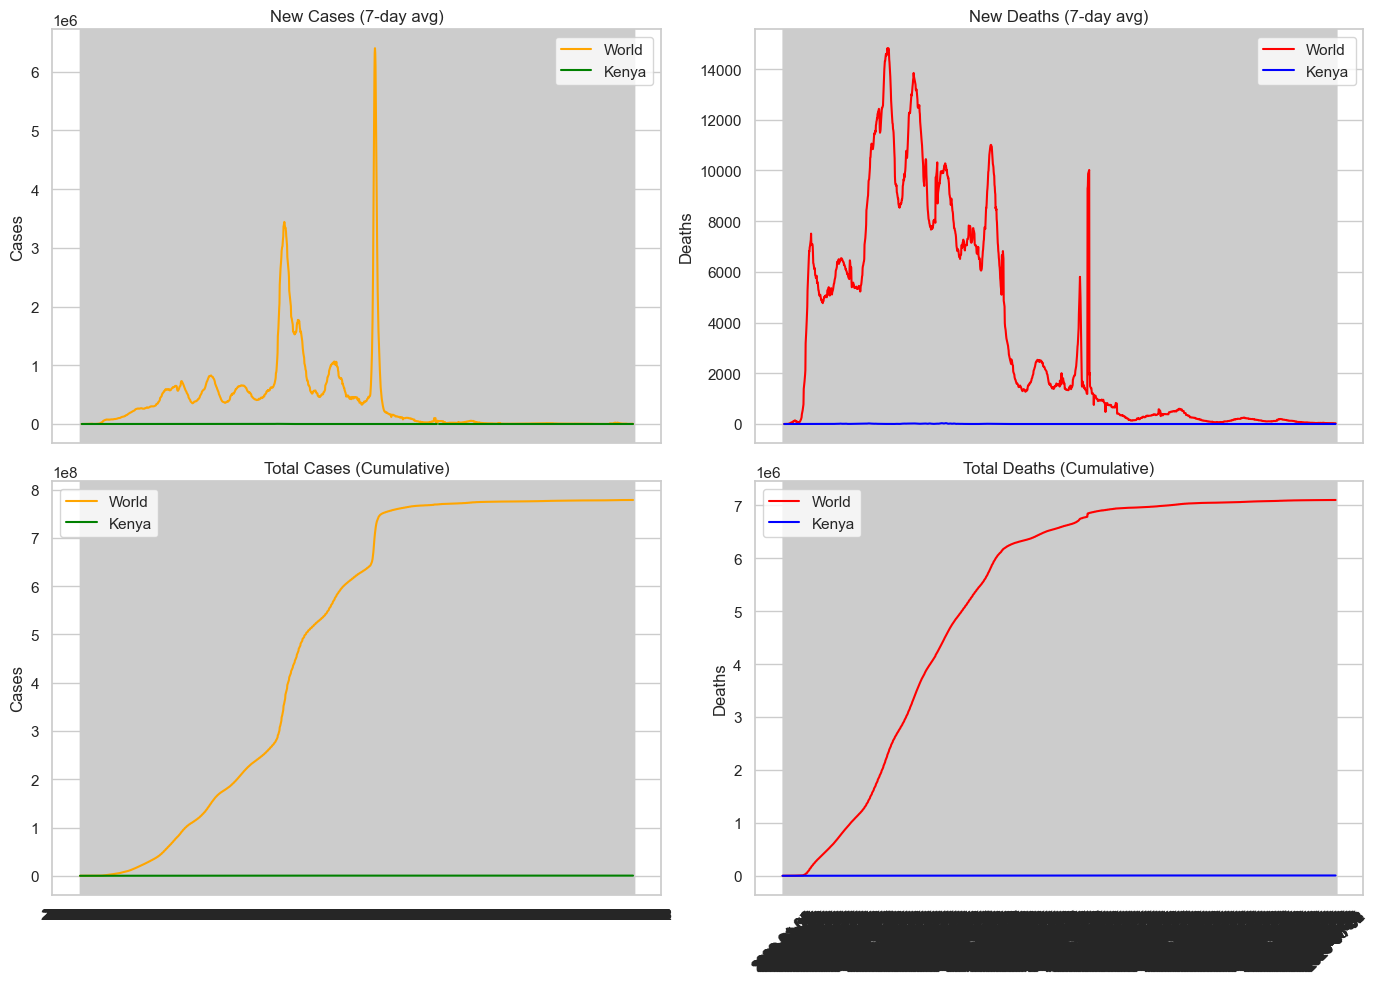

In [10]:
import matplotlib.pyplot as plt

# Filter World and Kenya
world = df[df["country"] == "World"].copy()
kenya = df[df["country"] == "Kenya"].copy()

# Apply 7-day rolling average for smoothing
world["new_cases_smoothed"] = world["new_cases"].rolling(7).mean()
kenya["new_cases_smoothed"] = kenya["new_cases"].rolling(7).mean()
world["new_deaths_smoothed"] = world["new_deaths"].rolling(7).mean()
kenya["new_deaths_smoothed"] = kenya["new_deaths"].rolling(7).mean()

# Create 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(14,10), sharex=True)

# --- New Cases (Smoothed) ---
axes[0,0].plot(world["date"], world["new_cases_smoothed"], label="World", color="orange")
axes[0,0].plot(kenya["date"], kenya["new_cases_smoothed"], label="Kenya", color="green")
axes[0,0].set_title("New Cases (7-day avg)")
axes[0,0].set_ylabel("Cases")
axes[0,0].legend()

# --- New Deaths (Smoothed) ---
axes[0,1].plot(world["date"], world["new_deaths_smoothed"], label="World", color="red")
axes[0,1].plot(kenya["date"], kenya["new_deaths_smoothed"], label="Kenya", color="blue")
axes[0,1].set_title("New Deaths (7-day avg)")
axes[0,1].set_ylabel("Deaths")
axes[0,1].legend()

# --- Total Cases (Cumulative) ---
axes[1,0].plot(world["date"], world["total_cases"], label="World", color="orange")
axes[1,0].plot(kenya["date"], kenya["total_cases"], label="Kenya", color="green")
axes[1,0].set_title("Total Cases (Cumulative)")
axes[1,0].set_ylabel("Cases")
axes[1,0].legend()

# --- Total Deaths (Cumulative) ---
axes[1,1].plot(world["date"], world["total_deaths"], label="World", color="red")
axes[1,1].plot(kenya["date"], kenya["total_deaths"], label="Kenya", color="blue")
axes[1,1].set_title("Total Deaths (Cumulative)")
axes[1,1].set_ylabel("Deaths")
axes[1,1].legend()

# Rotate x-axis for readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
# 📝 Quick insights to display in the notebook
import numpy as np

world = df[df["country"] == "World"].copy()
kenya = df[df["country"] == "Kenya"].copy()

def last_non_null(s):
    s2 = s.dropna()
    return s2.iloc[-1] if len(s2) else np.nan

insights = {
    "World_total_cases": last_non_null(world["total_cases"]),
    "World_total_deaths": last_non_null(world["total_deaths"]),
    "Kenya_total_cases": last_non_null(kenya["total_cases"]),
    "Kenya_total_deaths": last_non_null(kenya["total_deaths"]),
}

for k, v in insights.items():
    print(f"{k}: {v:,.0f}" if pd.notna(v) else f"{k}: n/a")

World_total_cases: 778,384,946
World_total_deaths: 7,098,868
Kenya_total_cases: 344,136
Kenya_total_deaths: 5,689
